In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_palette('colorblind'); sns.set_color_codes()
from theano import tensor as tt

%load_ext watermark
%watermark -dmvgp numpy,pymc3,theano

2017-01-24 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.1
pymc3 3.0
theano 0.8.2

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 15.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : 4b848bb1bdd66ee394a1e3b583138752a04154dd


## Varying slopes by construction

#### Code 13.1-13.5

In [2]:
a = 3.5  # average morning wait time
b = -1  # average difference afternoon wait time
sigma_a = 1  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes
Mu = [a, b]  

I'll use the second method to create covariance matrices as it's more versatile - it uses matrix multiplication instead of manually specifying the covariances.

In [3]:
Rho = np.matrix([[1, rho], [rho, 1]])
Rho

matrix([[ 1. , -0.7],
        [-0.7,  1. ]])

In [4]:
sigmas = [sigma_a, sigma_b]
Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)
Sigma

matrix([[ 1.  , -0.35],
        [-0.35,  0.25]])

#### Code 13.6-13.9

In [5]:
N_cafes = 20
np.random.seed(42)
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)
vary_effects.shape

(20, 2)

Instead of having individual arrays `a_cafe` and `b_cafe`, I'll place all these values in a DataFrame for easy manipulation.

In [6]:
df = pd.DataFrame(vary_effects, columns = ['a_cafe', 'b_cafe'])
df.head()

,a_cafe,b_cafe
0,2.990071,-0.848751
1,3.044156,-0.272349
2,3.703643,-1.164509
3,2.026929,-0.143253
4,4.032522,-1.014692


In [7]:
df.describe()

,a_cafe,b_cafe
count,20.000000,20.000000
mean,3.642714,-1.150220
std,0.893817,0.462307
min,2.017721,-1.849860
25%,3.039372,-1.427513
50%,3.803195,-1.312069
75%,4.251981,-0.973206
max,5.142855,-0.143253


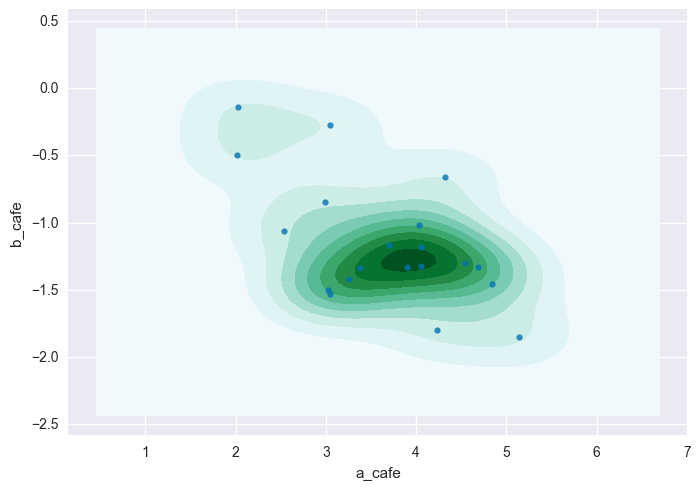

In [8]:
# Instead of using confidence region ellipses, I'll be using KDEs
# (Seaborn doesn't have this functionality)
# Unfortunately sns.jointplot can't overlay the scatter plot and the KDE
# Otherwise can use formula below:
#_ = sns.jointplot(df.a_cafe, df.b_cafe, kind='scatter')

# Will plot them separately but on the same plot
_ = sns.kdeplot(df.a_cafe, df.b_cafe, shade=True)  # KDE plot (substitute for confidence ellipses)
_ = sns.regplot(df.a_cafe, df.b_cafe, fit_reg=False)  # scatter plot with no regression line

#### Code 13.10 (Simulate the observations)

In [9]:
N_visits = 10
afternoon = np.tile([0,1], int(N_visits * N_cafes/2))  # wrap with int() to suppress warnings
afternoon[:10]

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [10]:
cafe_id = np.tile(np.arange(1, N_cafes+1), N_visits)  # 1-20
cafe_id[:25]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20,  1,  2,  3,  4,  5])

In [11]:
# Replicate df (which contains a_cafe and b_cafe) N_visits times to get full
# design matrix
d = pd.concat([df]*N_visits)\
    .reset_index(drop=True)
d['cafe_id'] = cafe_id
d['afternoon'] = afternoon
d['mu'] = d['a_cafe'] + d['b_cafe'] * d['afternoon']
sigma = 0.5  # std dev within cafes
wait = np.random.normal(d['mu'], np.repeat(sigma, len(d)))
d['wait'] = wait

d.head(25)

,a_cafe,b_cafe,cafe_id,afternoon,mu,wait
0,2.990071,-0.848751,1,0,2.990071,3.359304
1,3.044156,-0.272349,2,1,2.771807,2.857491
2,3.703643,-1.164509,3,0,3.703643,3.645819
3,2.026929,-0.143253,4,1,1.883676,1.733124
4,4.032522,-1.014692,5,0,4.032522,3.293261
5,3.902747,-1.326314,6,1,2.576433,2.216511
6,3.025019,-1.501163,7,0,3.025019,2.794700
7,5.142855,-1.849860,8,1,3.292996,3.821557
8,4.543745,-1.298342,9,0,4.543745,4.715554
9,4.227803,-1.795009,10,1,2.432794,1.551274


## The Varying Slopes Model

#### Code 13.12-13.13

Partially adapted from:
- http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/
- https://pymc-devs.github.io/pymc3/notebooks/LKJ.html

In [12]:
cafe_idx = d['cafe_id'].values - 1  # index for cafe_id. Python is 0-indexed
# Model specification on pg 393, but pymc3 requires us to go from bottom to top
with pm.Model() as hierarchical_model:
    
    sigma_a = pm.HalfCauchy('sigma_a', beta=1)  # prior stddev among intercepts
    sigma_b = pm.HalfCauchy('sigma_b', beta=1)  # prior stddev among intercepts
    # We need to create a matrix with sigma on diagonal, 0 everywhere else.
    # tt.nlinalg.diag is equivalent to np.diag() used above
    sigma_diag = pm.Deterministic('sigma_diag', tt.nlinalg.diag([sigma_a, sigma_b]))
    
    sigma = pm.HalfCauchy('sigma', beta=1)      # prior stddev within cafes

    rho = pm.LKJCorr('rho', n=2, p=2)  # prior for correlation matrix. n is shape parameter, p is dimension
    # There is a slight complication in how PyMC3 handles LKJCorr values.
    # It only returns the upper triangular elements. But we need a full matrix, in Theano's
    # tensor format.
    # See https://pymc-devs.github.io/pymc3/notebooks/LKJ.html
    # The next line creates the correlation matrix Rho (1 on diagonals). 
    # Index by np.zeros just sets all values in matrix to rho, then tt.fill_diagonal fills diagonals with 1
    Rho = pm.Deterministic('Rho', tt.fill_diagonal(rho[np.zeros((2, 2), dtype=np.int64)], 1.))
    # finally, the covariance matrix
    cov = pm.Deterministic('cov', tt.nlinalg.matrix_dot(sigma_diag, Rho, sigma_diag))
    
    a = pm.Normal('a', mu=0, sd=10)  # prior for average intercept
    b = pm.Normal('b', mu=0, sd=10)  # prior for average slope
    
    ab_cafe = pm.MvNormal('ab_cafe', mu=tt.stack([a,b]), cov=cov, shape=(N_cafes, 2)) # Population of varying effects
    # Shape needs to be (N_cafes, 2) because we're getting back both a and b for each cafe
    
    mu = ab_cafe[:, 0][cafe_idx] + ab_cafe[:, 1][cafe_idx] * d['afternoon'].values  # linear model
    wait = pm.Normal('wait', mu=mu, sd=sigma, observed=d['wait'])  # likelihood

In [13]:
# Run inference. 
# For this problem, metropolis is sufficient and fastest. (this code takes about 1 minute)
# Find MAP to get faster convergence
# Using more iterations than the book because Metropolis takes a while to converge
# (book uses Hamiltonian Monte Carlo)
# Using ADVI inference also sometimes leads to singular matrix errors... (not sure why)
num_samples = 50000
warmup = int(num_samples/2)
with hierarchical_model:
    step = pm.Metropolis()
    map_estimate = pm.find_MAP()
    trace = pm.sample(num_samples, step, start=map_estimate, random_seed=42)

         Current function value: -18.707054
         Iterations: 154
         Function evaluations: 281
         Gradient evaluations: 262


100%|██████████| 50000/50000 [01:17<00:00, 648.58it/s]


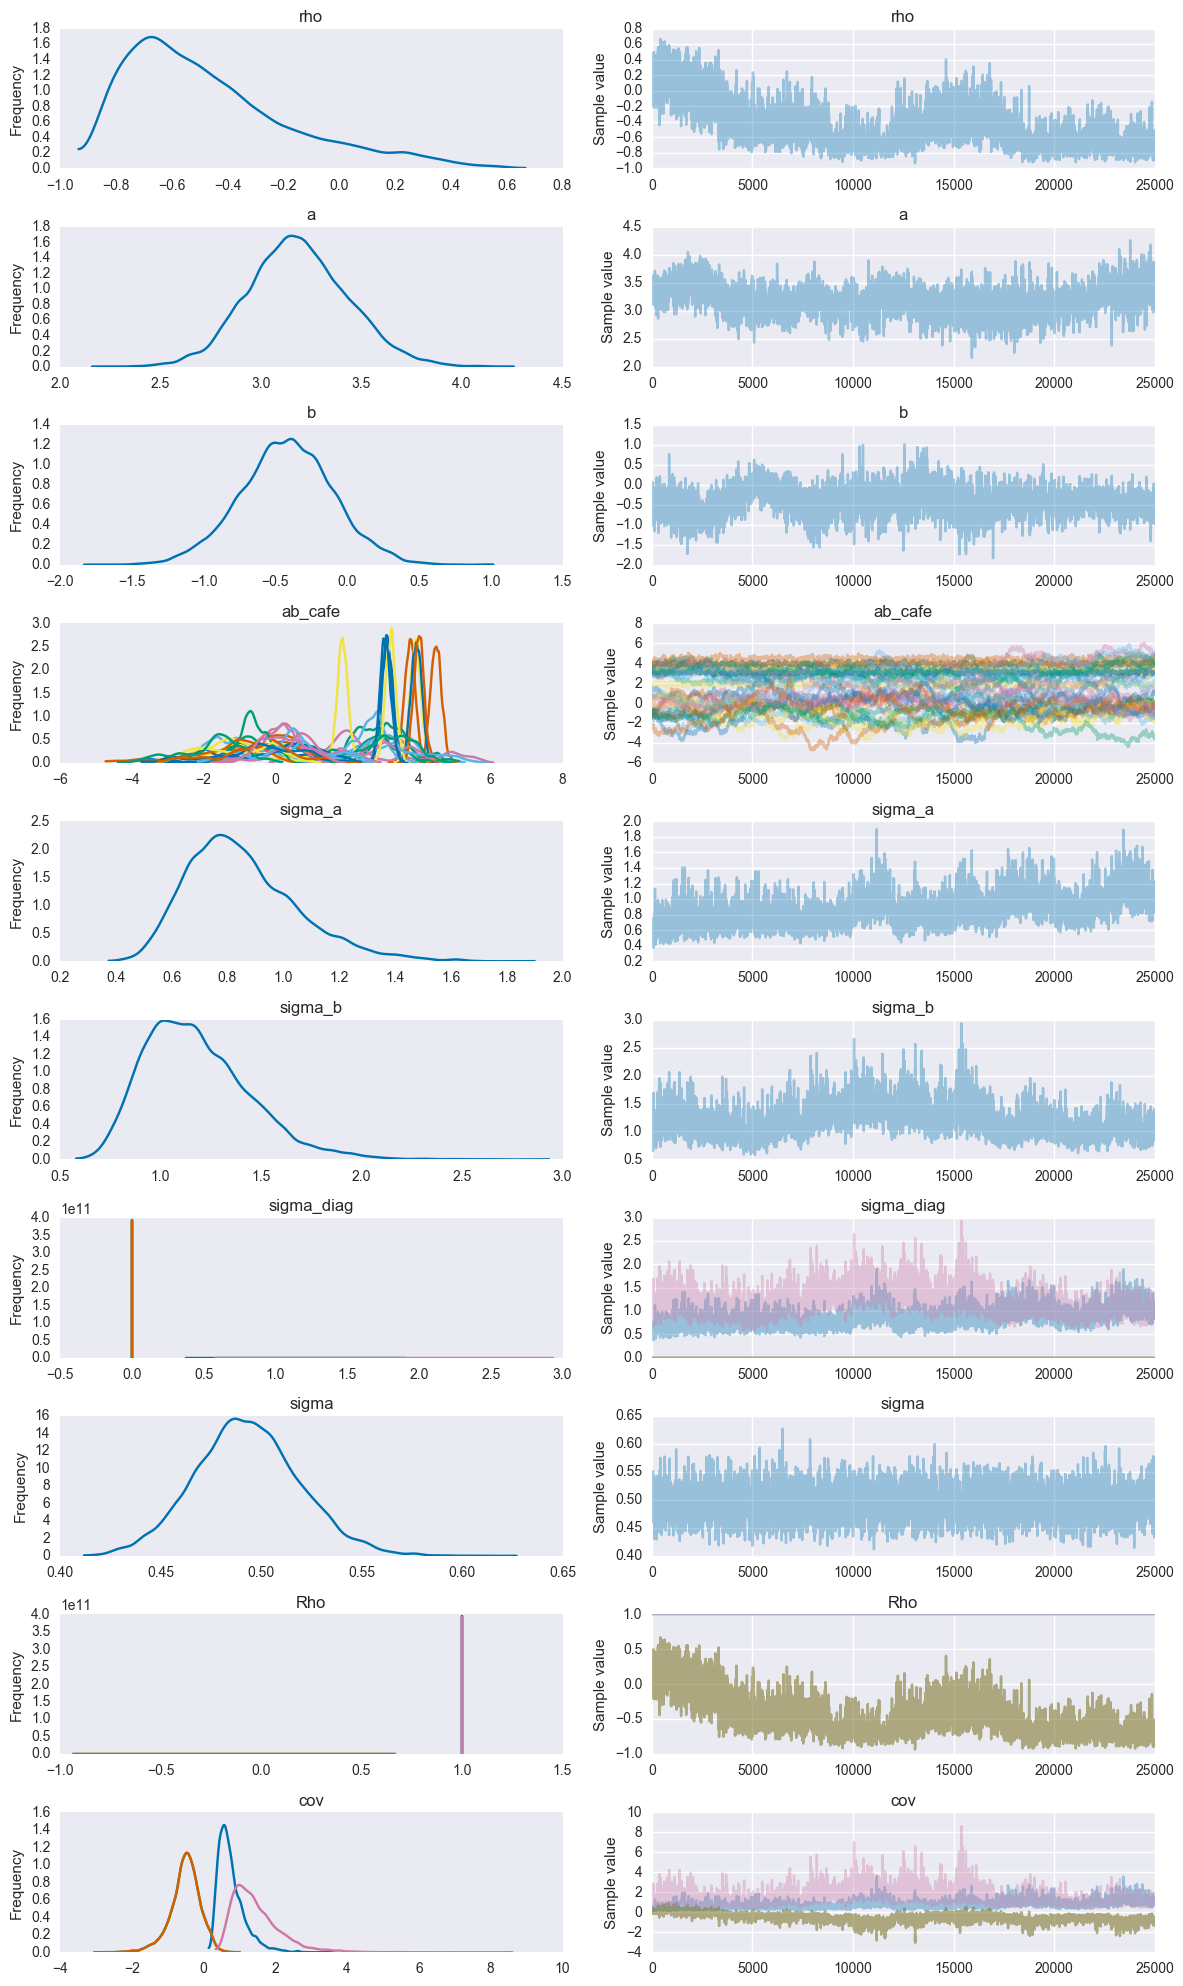

In [14]:
_ = pm.traceplot(trace[warmup:])

Looks good! The model seems to be able to recover the initial values `a`, `b`, `rho` and `sigma`s.

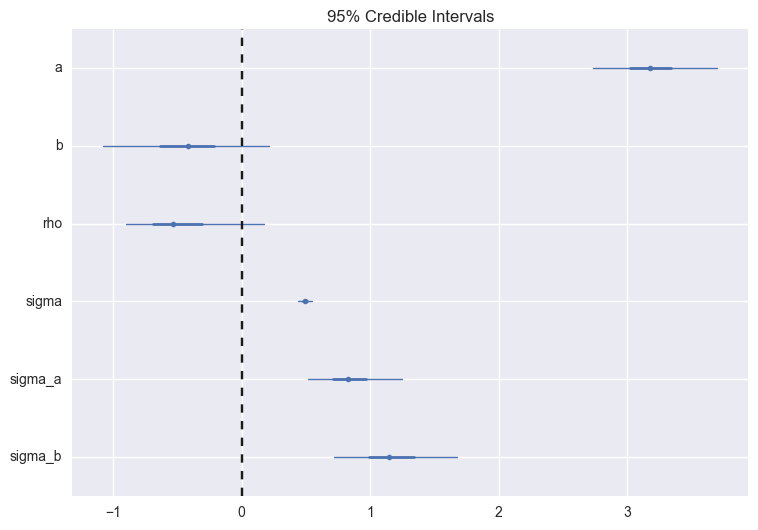

In [15]:
_ = pm.forestplot(trace[warmup:], varnames=['a', 'b', 'rho', 'sigma', 'sigma_a', 'sigma_b'])

In [16]:
trace_df = pm.trace_to_dataframe(trace[warmup:], hide_transformed_vars=False)
trace_df.head()

,b,a,Rho__0_0,Rho__0_1,Rho__1_0,Rho__1_1,sigma_b,sigma_a_log_,ab_cafe__0_0,ab_cafe__0_1,...,sigma_log_,sigma_diag__0_0,sigma_diag__0_1,sigma_diag__1_0,sigma_diag__1_1,sigma_a,cov__0_0,cov__0_1,cov__1_0,cov__1_1
0,-0.312146,3.399909,1.0,0.241863,0.241863,1.0,1.075231,-0.609472,2.999504,-1.150913,...,-0.700002,0.543638,0.0,0.0,1.075231,0.543638,0.295542,0.141378,0.141378,1.156122
1,-0.312146,3.399909,1.0,0.241863,0.241863,1.0,1.075231,-0.609472,2.969540,-1.097223,...,-0.700002,0.543638,0.0,0.0,1.075231,0.543638,0.295542,0.141378,0.141378,1.156122
2,-0.312146,3.208535,1.0,0.241863,0.241863,1.0,0.914531,-0.609472,2.969540,-1.097223,...,-0.700002,0.543638,0.0,0.0,0.914531,0.543638,0.295542,0.120248,0.120248,0.836366
3,-0.312146,3.208535,1.0,0.142670,0.142670,1.0,1.094357,-0.609472,3.052666,-1.160150,...,-0.700002,0.543638,0.0,0.0,1.094357,0.543638,0.295542,0.084879,0.084879,1.197617
4,-0.312146,3.208535,1.0,-0.047852,-0.047852,1.0,1.094357,-0.622603,3.052666,-1.160150,...,-0.748542,0.536546,0.0,0.0,1.094357,0.536546,0.287882,-0.028097,-0.028097,1.197617
